<a href="https://colab.research.google.com/github/kkk79/100-days-of-code/blob/master/NextWordPrediction_DeepLearning_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Next Word Prediction


In our multi-class classification problem, we will learn the relationships among our words and then provide probabilities as to which word should be next in our sequence. the model can only provide probabilities for words it has seen. 
We have used n-gram sequences and word embeddings to assist our model to learn the relationship between the words.

In [ ]:
# load the necessary libraries
import pandas as pd
import numpy as np
from google.colab import drive
import tensorflow as tf
import string, os
from keras import backend as K
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from nltk.tokenize import RegexpTokenizer
from keras.layers.core import Dense, Activation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re




# connect with google drive to fetch our dataset
from google.colab import drive 
drive.mount('/content/gdrive')
%cd '/content/gdrive/My Drive'


Mounted at /content/gdrive
/content/gdrive/My Drive


Our Dataset consists of lyrics from the 80's, extracted from kaggle. 
We have 231 songs in total.

In [ ]:
path = ("/content/gdrive/My Drive/Colab Notebooks/80s_detailed(1).csv")
text = pd.read_csv(path)
print('corpus length:', len(text))
text.head()

corpus length: 231


,Unnamed: 0,artist,date,featured_artists,lyrics,song,song_album,song_url,year
0,0,KC & the Sunshine Band,"January 5, 1980",[],"I love you Yeah Babe, I love you so I want you...",Please Don't Go,Do You Wanna Go Party,https://genius.com/Kc-and-the-sunshine-band-pl...,"5,"
1,1,Michael Jackson,"January 19, 1980",[],"Girl, close your eyes Let that rhythm get into...",Rock with You,Off the Wall,https://genius.com/Michael-jackson-rock-with-y...,"19,"
2,2,Captain & Tennille,"February 16, 1980",[],Do that to me one more time Once is never enou...,Do That to Me One More Time,Make Your Move,https://genius.com/Captain-and-tennille-do-tha...,"16,"
3,3,Queen,"February 23, 1980",[],This thing called love I just can't handle it ...,Crazy Little Thing Called Love,The Game,https://genius.com/Queen-crazy-little-thing-ca...,"23,"
4,4,Pink Floyd,"March 22, 1980",[],We don't need no education We don't need no th...,Another Brick in the Wall (Part 2),The Wall,https://genius.com/Pink-floyd-another-brick-in...,"22,"


In [ ]:
text.info()
text.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231 entries, 0 to 230
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        231 non-null    int64 
 1   artist            231 non-null    object
 2   date              231 non-null    object
 3   featured_artists  216 non-null    object
 4   lyrics            216 non-null    object
 5   song              231 non-null    object
 6   song_album        208 non-null    object
 7   song_url          216 non-null    object
 8   year              231 non-null    object
dtypes: int64(1), object(8)
memory usage: 16.4+ KB


(231, 9)

216 unique characters


In [ ]:
print("Number of unique characters:", len(set(text['lyrics'])))


Number of unique characters: 216


We only need the lyrics feature. Kept only the first 70 songs.
 Clean our dataset, by lowercasing the words - to avoid duplicated ones- , removing tags, punctuation, numbers and spaces

In [ ]:
text = text.astype(str)
cor = text['lyrics'][:50]

def clean_text(cor):
 
#Remove punctuations and numbers
  cor = re.sub("((\S+)?(\S+))|((\S+)?(\S+))|((\S+)?(\@)(\S+)?)", " ", cor)
  cor = re.sub("[^a-zA-Z]", " ", "1-2", "(", ")", cor)
# Single character removal
  cor = re.sub(r"\s+[a-zA-Z]\s+", ' ', cor)
# Removing multiple spaces
  cor = re.sub(r'\s+', ' ', cor)
cor = cor.str.split().str.join(" ")
cor


0     I love you Yeah Babe, I love you so I want you...
1     Girl, close your eyes Let that rhythm get into...
2     Do that to me one more time Once is never enou...
3     This thing called love I just can't handle it ...
4     We don't need no education We don't need no th...
5     1898 A Trip to the Moon 1903 The Great Train R...
6     {Intro} Gotta make a move to a town that's rig...
7     You want a love to last forever One that will ...
8     What's the matter with the clothes I'm wearing...
9     Come take my hand You should know me I've alwa...
10    Well, it's not far down to paradise At least i...
11    I said, "Upside down, you're turning me." You'...
12    Ooh, let's go! Steve walks warily down the str...
13    Life is a moment in space When the dream is go...
14    Lady, I'm your knight in shining armor And I l...
15    Our life together is so precious together We h...
16    The tide is high but I'm holdin' on I'm gonna ...
17    (This is your celebration) (This is your c

We combine all the lines of the lyrics into a joined text / a series of strings. 



In [ ]:
#combine all the snippets into a series of strings

snippet = '\n'.join(cor)
print(snippet)
print(type(snippet))

I love you Yeah Babe, I love you so I want you to know That I'm gonna miss your love The minute you walk out that door So please don't go Don't go Don't go away Please don't go Don't go I'm begging you to stay If you leave, at least in my lifetime I've had one dream come true I was blessed to be loved By someone as wonderful as you So please don't go Don't go Don't go away Please don't go Don't go I'm begging you to stay Hey, hey, hey Yeah Babe, I love you so I, I want you to know That I'm gonna miss your love The minute you walk out that door So please don't go Don't go Don't go away Hey, hey, hey I need your love I'm down on my knees Beggin' please, please, please Don't go Don't you hear me, baby? Don't leave me now Oh, no, no, no, no Please don't go I want you to know That I, I, I love you so Please don't leave me, baby Please don't go
Girl, close your eyes Let that rhythm get into you Don't try to fight it There ain't nothin' that you can do Relax your mind Lay back and groove with

the lower() function has transformed our string into a list of strings.

In [ ]:
# the text contains  unique snippets

cor = snippet.lower().split('\n')
print(cor[:2]) #snippets


["i love you yeah babe, i love you so i want you to know that i'm gonna miss your love the minute you walk out that door so please don't go don't go don't go away please don't go don't go i'm begging you to stay if you leave, at least in my lifetime i've had one dream come true i was blessed to be loved by someone as wonderful as you so please don't go don't go don't go away please don't go don't go i'm begging you to stay hey, hey, hey yeah babe, i love you so i, i want you to know that i'm gonna miss your love the minute you walk out that door so please don't go don't go don't go away hey, hey, hey i need your love i'm down on my knees beggin' please, please, please don't go don't you hear me, baby? don't leave me now oh, no, no, no, no please don't go i want you to know that i, i, i love you so please don't leave me, baby please don't go", "girl, close your eyes let that rhythm get into you don't try to fight it there ain't nothin' that you can do relax your mind lay back and groove

Tokenize the corpus, meaning we transform each unique word into a numerical value, which is easier for the algorithm to understand.Tokenizing is the process in which we provide a unique id to all the words and make a word index. Kera's tokenizer also ranges the word according to their frequencies. The most frequent word as a key takes the value: 1. 
We have 2356 unique words in our dataset. 
Calculate the length size by using the length that 'tokenizer.word_index' provides us and add 1 ( because 0 is reserved for padding)and start our count at 1. 

In [ ]:
# Split into each word. Kera's tokenizer also ranges them ( 1 is the most frequent word) This text has 5168unique words
tokenizer=Tokenizer ()
tokenizer.fit_on_texts(cor)
word_index=tokenizer.word_index
total_unique_words=len(tokenizer.word_index) + 1
print(total_unique_words)
print(word_index)
print ("Day :", tokenizer.word_index['day'])

2538
{'the': 1, 'you': 2, 'i': 3, 'and': 4, 'to': 5, 'me': 6, 'a': 7, 'love': 8, 'my': 9, 'of': 10, 'that': 11, 'in': 12, 'your': 13, 'it': 14, "don't": 15, 'oh': 16, 'on': 17, "it's": 18, 'can': 19, 'do': 20, 'is': 21, 'for': 22, 'be': 23, 'take': 24, 'one': 25, 'up': 26, 'all': 27, 'so': 28, 'we': 29, 'with': 30, "can't": 31, "i'm": 32, 'just': 33, 'know': 34, 'no': 35, 'when': 36, 'yeah': 37, 'go': 38, 'time': 39, 'nah': 40, 'out': 41, "you're": 42, 'come': 43, 'night': 44, 'like': 45, 'mickey': 46, 'but': 47, 'baby': 48, 'want': 49, 'down': 50, 'get': 51, 'she': 52, 'another': 53, 'have': 54, "'round": 55, 'where': 56, 'gonna': 57, 'what': 58, 'rock': 59, 'kiss': 60, 'away': 61, 'now': 62, 'say': 63, 'he': 64, 'here': 65, 'day': 66, 'man': 67, 'hey': 68, 'from': 69, "won't": 70, "i'll": 71, 'see': 72, 'good': 73, 'if': 74, 'girl': 75, 'every': 76, 'eyes': 77, 'never': 78, 'again': 79, 'this': 80, 'they': 81, 'celebrate': 82, 'back': 83, 'wanna': 84, 'watching': 85, 'by': 86, 'who':

Since our dataset has no labels, we use n-grams for splitting our data in order to derive the labels. An n_gram is a sequence of words (n) sizes long. Each sentence will be converted into a sequence with their respective tokens. More specifically, we iterated over each tokenized snippet to create n_grams the size of n_gram+1 sequence map. We achieved it by creating an empty list which holds our n_gram sequences. Next, we iterate over our corpus of untokenized snippets and apply the “texts_to_sequences” method to each untokenized snippet. The “texts_to_sequences” method converts each snippet to its tokenized version. By calling tokenizer method texts_to_sequences we convert sequences of text to sequences of numbers. The resulting seqences can then be used to generate n_gram sequences. Next, we iterate over each token beginning with the second (index=1) throught all remaining tokens. At each iteration, we append the sequence of n_grams to input_sequences and expand the n_gram+1.


In [ ]:
# our dataset doesnot have labeled values, so we will use n_gram
# we will apply the text_to_sequences method to each snippet.
input_sequences=[]
for line in cor:
  token_list=tokenizer.texts_to_sequences([line])[0]
  for i in range(1, len(token_list)):
      n_gram_seqs=token_list[:i+1]
      input_sequences.append(n_gram_seqs)
print(len(input_sequences))
#print(input_sequences)

15438


Next, we formatted each sequence of n_grams to be of the same length. Infact, we made a sequence of n_grams with zeros to the length to the longest n_gram=  Max_seq_length This is called padding of n-grams. The “pad_sequences” method will add zeros prior to our tokens  = 3758
It prints our  (2511 values of) features and (the 2512nd )labels for the first 2 rows. 

In [ ]:
#n_grams should be on the same length 
max_sequence_len=max([len(x) for x in input_sequences])
input_seqs=np.array(pad_sequences (input_sequences, maxlen=max_sequence_len, padding="pre"))
print(max_sequence_len)  
print(input_seqs[:2]) # samples


2512
[[0 0 0 ... 0 3 8]
 [0 0 0 ... 3 8 2]]


use a pre-trained word embeddings model from Stanford University named “GloVe” (Global Vectors for Word Representation) and we will use the 50-dimensional version. 
Word embeddings enable us to represent words in a n_dimensional space, where similar in meaning words are close in space.
Glove dictionary contains the word/character as the key and a 50-dimensional array as the value.



In [ ]:
# we will make use of a pre-trained word embeddings model "Glove" 6B 50 dimensional arrays
path = '/content/gdrive/MyDrive/Colab Notebooks/glove.6B.50d.txt'
embeddings_index={}
with open(path) as f:
 for line in f:
    values=line.split()
    word=values[0]
    coeffs=np.array(values[1:], dtype='float32')
    embeddings_index[word] = coeffs
    #dict(list(embeddings_index.items())[0:2])

Create a matrix containing the 50-dimensional arrays of Glove x the unique words of our vocabulary. We create a matrix of zeros with the shape of 2356 ( our unique words) by 50(50-dimensional arrays of Glove) . Then iterate over the “word_index” which contains the unique words in our corpus as the keys and their corresponding tokens as the values. At each iteration through the word_index dictionary, we fetched the corresponding GloVe embeddings save it in “embeddings_index” and update the embeddings_matrix

In [ ]:
#matrix with 5168 unique words X 50 dimensional arrays of Glove
embeddings_matrix = np.zeros((total_unique_words, 50))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embeddings_matrix[i] = embedding_vector;

Built a model consisting of an embedding layer,( our input layer) 3 LSTM layers, 3 dropout layers, and a fully connected Dense layer. The first layer being the Embedding layer enabled us to utilize the pre-trained GloVe word embeddings coefficients/weights. The embedding layer requires an input_dim of the total number of unique words in our corpus and an output_dim which specifies the number of word embedding dimensions we are waiting. We passed the embeddings_matrix into the weights argument in order to use the GloVe weights and set the trainable argument to “False”, otherwise, we’ll retrain the GloVe weights. Finally, we’ll set the input_length parameter to “max_seq_length -1”..... We used the dropout method for regularization. That means that during training randomly we set some activations to zero in each iteration. A Long Short-Term Memory (LSTM) model learns the relationships among words and allows the important relationships to propagate through the network. The LSTM core model contains LSTM cells that processes one word at a time and assigns probabilities of the most possible values for the next word in the sentence. We used a Bidirectional LSTM which learns the relationships among words reading the sentence from left-to-right and right-to-left. We use LSTM instead of RNN, because though RNN can connect past data to the present information; it gives some problem in long term dependencies. Moreover RNN suffer from vanishing and exploiting gradients problem. That is also the reason why we used Rely, an activation functions that don’t “squash” z into a limited range. We added 2 dropout layers (drop 20%) to help with the overfitting problem. We chose Adam as our optimizer and categorical_crossentropy as our loss function, since we have a multi-class classification problem. Adam (Adaptive Moment Estimation) which is adapting the learning rate to particular weights. It uses exponential moving average of the gradient and the square gradient.


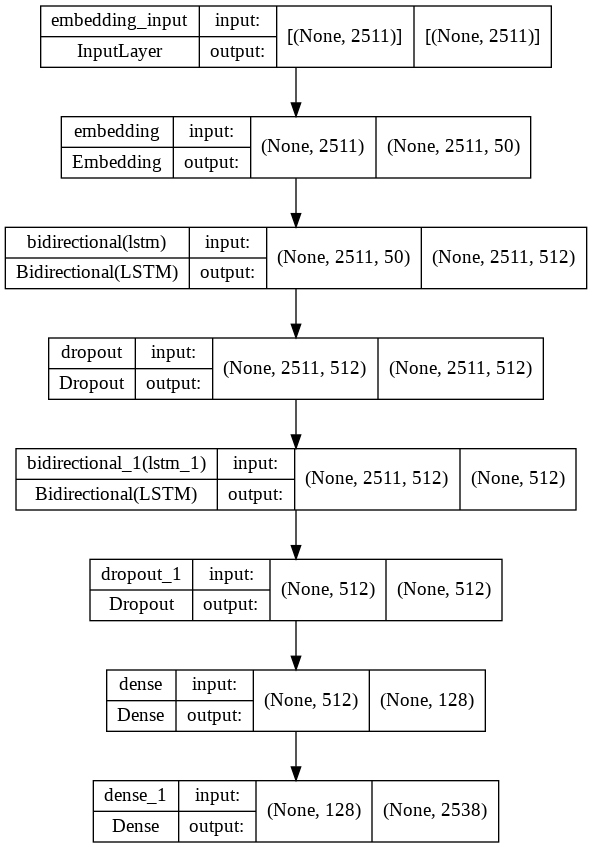

In [ ]:
# Build the model with Bidirectional LSTM
K.clear_session()
model=tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=total_unique_words, output_dim=50, weights=[embeddings_matrix], input_length=max_sequence_len-1, trainable=False), 
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)), 
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256)),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(total_unique_words, activation="softmax")])

model.compile(optimizer=Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=['accuracy'])

tf.keras.utils.plot_model(model,show_shapes=True)


Fit our model with the x and y values. Batches of 32 and 20 training times is used. Within the training set, 20% of the data is reserved for model validation during training (validation_split = 0.2). 
We Could have created checkpoint to save the best values of all the parameters of the model.

In [ ]:
# Train the model
x_values, labels = input_seqs[:, :-1], input_seqs[:,-1]
y_values = tf.keras.utils.to_categorical(labels,num_classes=total_unique_words)

history = model.fit(x_values, y_values, epochs=30, validation_split=0.2, verbose=1, batch_size=32)


Epoch 1/30
386/386 [==============================] - 268s 666ms/step - loss: 6.3660 - accuracy: 0.0558 - val_loss: 6.5090 - val_accuracy: 0.0512
Epoch 2/30
386/386 [==============================] - 256s 665ms/step - loss: 5.9138 - accuracy: 0.0709 - val_loss: 6.6333 - val_accuracy: 0.0450
Epoch 3/30
386/386 [==============================] - 258s 668ms/step - loss: 5.7084 - accuracy: 0.0823 - val_loss: 6.7609 - val_accuracy: 0.0486
Epoch 4/30
386/386 [==============================] - 258s 668ms/step - loss: 5.5040 - accuracy: 0.0868 - val_loss: 6.8300 - val_accuracy: 0.0589
Epoch 5/30
386/386 [==============================] - 257s 667ms/step - loss: 5.2975 - accuracy: 0.0968 - val_loss: 6.8278 - val_accuracy: 0.0508
Epoch 6/30
386/386 [==============================] - 257s 667ms/step - loss: 5.0534 - accuracy: 0.1134 - val_loss: 6.8556 - val_accuracy: 0.0538
Epoch 7/30
386/386 [==============================] - 257s 665ms/step - loss: 4.8085 - accuracy: 0.1385 - val_loss: 7.0029 -

Check our model in snippets which it hasn’t seen before. Seed the model with unseen snippets and see the model’s prediction. for _ in... this is like a place holder, which upholds the syntax. We use it when we don't want to use the variable, so we leave it empty. Next, we do the same things to the input as we did when training the model. Then gets the word corresponding the value predicted, converting from numeric to string again

In [ ]:

def complete_this_song(seed_text, next_words):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted = np.argmax(model.predict(token_list), axis=-1)
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word   
                break
        seed_text += " " + output_word
    return seed_text
complete_this_song("if you want to know what the reason is I only smile when i Lie, then i will", 3)


'if you want to know what the reason is I only smile when i Lie, then i will though rock with'

Actual lyrics:  if you want to know what the reason is I only smile when i Lie, then i will tell you why

In [ ]:
complete_this_song("We don't need no education We don't need no thought control No dark sarcasm in the classroom Teacher, ", 3)

"We don't need no education We don't need no thought control No dark sarcasm in the classroom Teacher,  leave them kids"

Actual lyrics : We don't need no education We don't need no thought control No dark sarcasm in the classroom Teacher, leave them kids

In [ ]:
complete_this_song("There's a party goin' on right here A celebration to last throughout the years So bring your good times and your laughter too", 5)

"There's a party goin' on right here A celebration to last throughout the years So bring your good times and your laughter too we gonna celebrate and be"

Actual lyrics: There's a party goin' on right here A celebration to last throughout the years So bring your good times and your laughter too 

In [ ]:
complete_this_song("you have to believe you're magic. Nothin' can", 3)

"you have to believe you're magic. Nothin' can stand in tucson"


Actual lyrics: you have to believe you're magic. Nothin' can stand in your way.


In [ ]:
complete_this_song("peace and understanding. So everybody can be free I know that we", 3)

'peace and understanding. So everybody can be free I know that we can sail you'

Actual text: peace and understanding. So everybody can be free I know that we can get together

In [ ]:
complete_this_song("been alone with you inside my mind. We are the one's", 3)

"been alone with you inside my mind. We are the one's words to say"

Actual lyrics: been alone with you inside my mind. We are the one's who made a brighter day.

In [ ]:
from tensorflow.keras.models import load_model
model.save('song_lyrics_generator.h5')


Plot loss and accuracy 

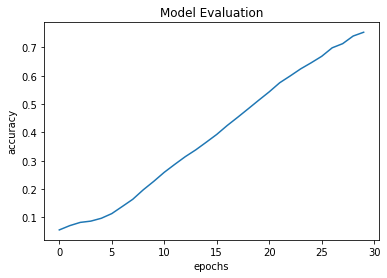

In [ ]:

import matplotlib.pyplot as plt
def plot_graph(history, string):
  plt.plot(history.history[string])
  plt.title("Model Evaluation")
  plt.xlabel("epochs")
  plt.ylabel(string)
  plt.show
plot_graph(history, 'accuracy')

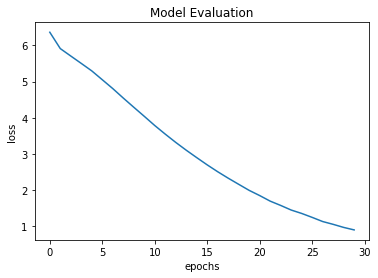

In [ ]:
plot_graph(history, "loss")

We see from the plot that we are far from optimal. Many more epochs are going to be needed till the model converge. Due to limited GPU it was not possible to continue.